# <center> Machine Learning Project: Car Brand Recognition </center>


* [**1. Introduction**](#ch1)
  * [1.1 Choix du sujet et objectif du projet](#ch1.1)
  * [1.2 Collecte des données](#ch1.2)
  
* [**2. Modèle de classification binaire**](#ch2)
  * [2.1 Définition du modèle et prédiction](#ch2.1)
  * [2.2 Etude des kernels](#ch2.2)
    * [2.2.1 Méthode "expérimentale"](#ch2.2.1)
    * [2.2.2 Méthode avec "activation map"](#ch2.2.2)
* [**3 Modèle de classification "Softmax"**](#ch3)

* [**4. Conclusion**](#ch3)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
from keras.preprocessing import image
import keras.backend as K
from keras import models
import cv2
import os
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

<a id="ch1"></a>

## 1. Introduction

<a id="ch1.1"></a>
### 1.1 Choice of subject and project objectives
Both passionate about cars, over the summer we had the idea of creating a “Shazam for cars,” similar to the well-known app that recognizes music by recording a short snippet. Because when you see a car on the street, it's not always easy to identify it. This semester, we had to think of a topic for our machine learning project. So it was only natural that we decided to focus on car recognition. Of course, it will be a simplified version to match the knowledge we have acquired since January in machine learning.  \
The objective is for our algorithm to distinguish between several brands based on a photograph of a given car.

<a id="ch1.2"></a>
### 1.2 Data Collection

Due to a lack of data on the internet, we decided to create our own samples. To start with, for our first model, we took photos of Peugeot and Renault vehicles from the front as they drove down the street. We chose these brands for practical reasons, as they are the most common brands in France. \\
We quickly realized that this was too time-consuming. So we expanded the samples by taking screenshots of cars for sale on the website *lacentrale.fr*. \\
For the second model, we kept the two brands Peugeot and Renault, but we added an “others” class where we put photos of various brands (BMW, Audi, Mercedes, Citroën, and Volkswagen), most of which also came from the website *lacentrale.fr*.
In total, we were able to obtain about 1,600 photos, distributed evenly.
The photos were then modified to make them square and to reduce their size to 512x512 pixels.

<a id="ch2"></a>

## 2. Modèle de classification binaire

On importe les modules nécessaires au fonctionnement de notre modèle.

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

#import vis
#from keras.applications.vgg16 import VGG16, preprocess_input
#from vis.utils import utils

### 2.1 Définition du modèle et prédiction

In [8]:
image_size = (512, 512)
batch_size = 16

On prend 80% de l'échantillon pour le training et 20% pour la validation.

In [ ]:
data_directory = "../data/2brands"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1043 files belonging to 2 classes.
Using 835 files for training.
Found 1043 files belonging to 2 classes.
Using 208 files for validation.


Ci-dessous, vous pouvez voir des exemples d'images servant à l'entrainement.

2025-08-26 17:15:04.309614: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


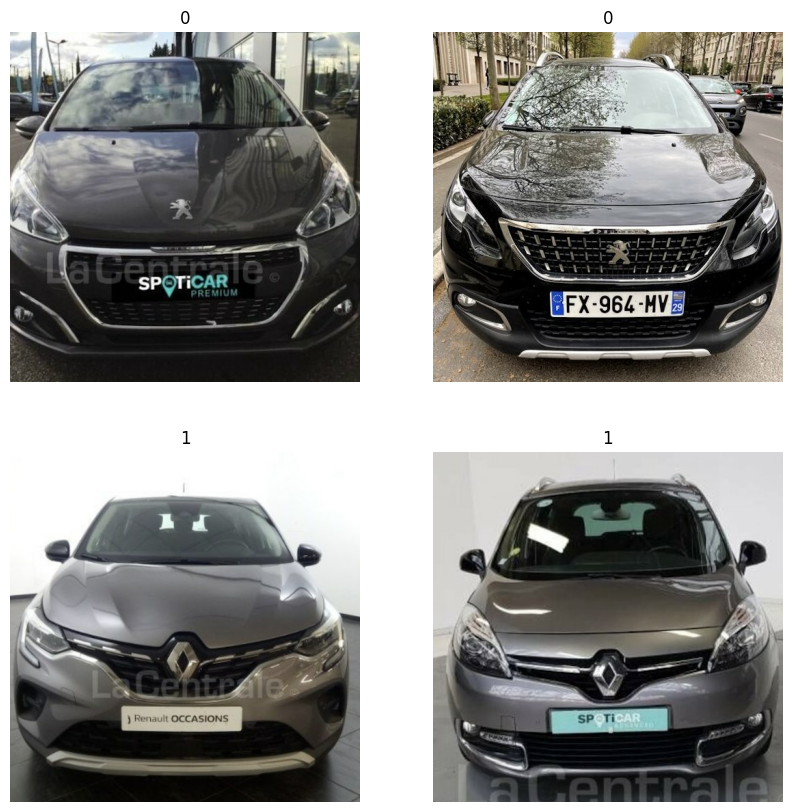

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Pour augmenter la taille de l'échantillon et le diversifier, nous avons réalisé un preprocessing qui induit une rotation aléatoire des images. \
Cela augmente le réalisme car une photo prise par quelqu'un n'est jamais parfaitement droite.

In [12]:
data_augmentation = keras.Sequential([
        layers.RandomRotation(0.05),
        #layers.experimental.preprocessing.RandomZoom(.5, .2)
        ])

Ci-dessous, vous pouvez voir l'effet du préprocessing sur une image.

2025-08-26 17:16:58.599555: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


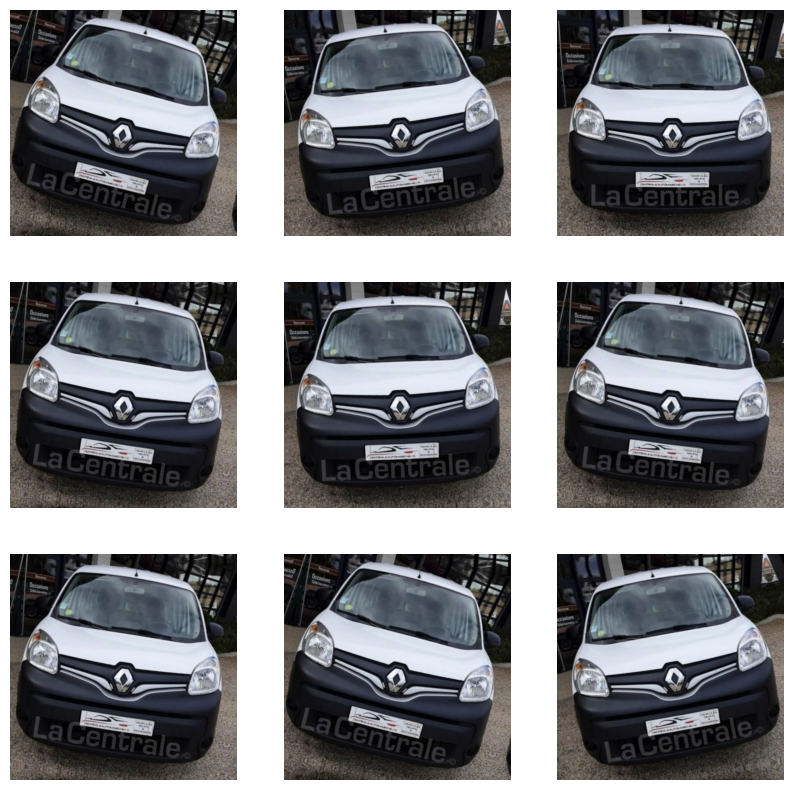

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Nous avons construit un modèle qui est un réseau de neurones. Celui-ci est basé sur un enchainement de convolution et de maxpooling.

In [16]:
def make_model(input_shape,num_classes):
  inputs = keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  #x = inputs
  x = layers.Rescaling(1./255)(x)

  x = Conv2D(16,3,padding='same',input_shape=(512,512,3),activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(32,3,padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(64,3,padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(128,3,padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Flatten()(x)
  outputs = Dense(1,activation='sigmoid')(x)
  return keras.Model(inputs, outputs)
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()
weights = model.get_weights()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,513 (892.63 KB)

 Trainable params: 228,513 (892.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
tf.keras.utils.plot_model(
    model, to_file="model.png", show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


On a remarqué que prendre 30 epochs était satisfaisant. En effet la courbe de la training loss après avoir diminué atteint bien un plateau comme attendu. De plus, la courbe de la validation loss suit celle de la training loss.

In [18]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_best.h5",save_best_only=True,),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history=model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.5462 - loss: 0.7466

53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 711ms/step - accuracy: 0.6000 - loss: 0.6803 - val_accuracy: 0.7212 - val_loss: 0.5732
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.7184 - loss: 0.5532

53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 727ms/step - accuracy: 0.7437 - loss: 0.5191 - val_accuracy: 0.8462 - val_loss: 0.3851
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 752ms/step - accuracy: 0.8527 - loss: 0.3539 - val_accuracy: 0.7308 - val_loss: 0.5100
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.8439 - loss: 0.3792

53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 747ms/step - accuracy: 0.8647 - loss: 0.3391 - val_accuracy: 0.9038 - val_loss: 0.2401
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.8892 - loss: 0.2618

53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 771ms/step - accuracy: 0.8898 - loss: 0.2678 - val_accuracy: 0.9279 - val_loss: 0.1842
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 802ms/step - accuracy: 0.9269 - loss: 0.1992 - val_accuracy: 0.9183 - val_loss: 0.2067
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 752ms/step - accuracy: 0.9449 - loss: 0.1522 - val_accuracy: 0.8462 - val_loss: 0.3276
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 744ms/step - accuracy: 0.9401 - loss: 0.1397 - val_accuracy: 0.9279 - val_loss: 0.2339
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 726ms/step - accuracy: 0.9557 - loss: 0.1299 - val_accuracy: 0.8413 - val_loss: 0.4804
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9420 - loss: 0.1328

53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 732ms/step - accuracy: 0.9593 - loss: 0.1036 - val_accuracy: 0.9279 - val_loss: 0.1644
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 721ms/step - accuracy: 0.9749 - loss: 0.0672 - val_accuracy: 0.9279 - val_loss: 0.1821
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9765 - loss: 0.0600

53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 745ms/step - accuracy: 0.9796 - loss: 0.0571 - val_accuracy: 0.9567 - val_loss: 0.1101
Epoch 13/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 784ms/step - accuracy: 0.9880 - loss: 0.0385 - val_accuracy: 0.9712 - val_loss: 0.1200
Epoch 14/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 724ms/step - accuracy: 0.9844 - loss: 0.0386 - val_accuracy: 0.8990 - val_loss: 0.3465
Epoch 15/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9797 - loss: 0.0550

53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 732ms/step - accuracy: 0.9772 - loss: 0.0570 - val_accuracy: 0.9760 - val_loss: 0.0919
Epoch 16/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 748ms/step - accuracy: 0.9892 - loss: 0.0275 - val_accuracy: 0.9615 - val_loss: 0.1300
Epoch 17/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9805 - loss: 0.0517

53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 732ms/step - accuracy: 0.9820 - loss: 0.0492 - val_accuracy: 0.9808 - val_loss: 0.0823
Epoch 18/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 737ms/step - accuracy: 0.9844 - loss: 0.0342 - val_accuracy: 0.9808 - val_loss: 0.1068
Epoch 19/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 746ms/step - accuracy: 0.9952 - loss: 0.0196 - val_accuracy: 0.9615 - val_loss: 0.1423
Epoch 20/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 731ms/step - accuracy: 0.9976 - loss: 0.0119 - val_accuracy: 0.9856 - val_loss: 0.0966
Epoch 21/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 744ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9760 - val_loss: 0.0960
Epoch 22/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 741ms/step - accuracy: 0.9952 - loss: 0.0193 - val_accuracy: 0.9712 - val_loss: 0.1263
Epoch 23/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 754ms/step - accuracy: 0.9988 - loss: 0.0081 - val_accuracy: 0.9712 - val_loss: 0.0983
Epoch 24/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 765ms/step - accuracy: 0.9928 - loss: 0.0211 - val_accuracy

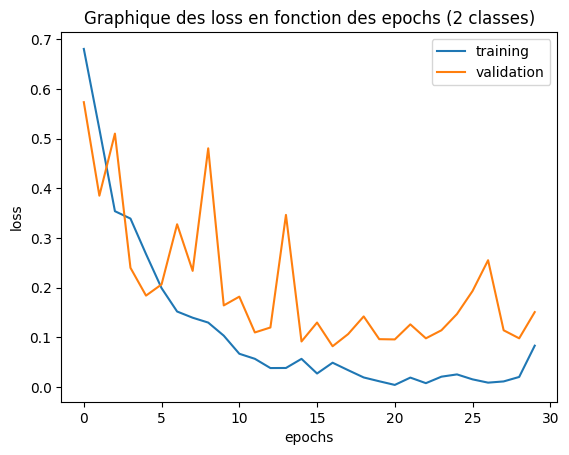

In [20]:
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title('Graphique des loss en fonction des epochs (2 classes)')
plt.xlabel('epochs'); plt.ylabel('loss'); plt.legend()

Lors de nos premiers essais, nous n'avions pas de preprocessing. Nous n'obtenions pas des courbes satisfaisantes: la validation loss s'éloignait trop de la training loss. Vous trouverez ci-dessous la courbe de la loss de ce modèle:

In [21]:
image2=mpimg.imread("donnees_comp/graphs/sansPreprocessing.png")
plt.imshow(image2)

FileNotFoundError: [Errno 2] No such file or directory: 'donnees_comp/graphs/sansPreprocessing.png'

On extrait la meilleure epoch.

In [ ]:
model.load_weights("save_best.h5")

On définit une fonction permettant de tester le modèle pour une image au choix et qui prédit à quelle marque appartient la voiture sur cette image avec le pourcentage de certitude de l'algorithme.

In [ ]:
def predict2marques(path_image):
  image=mpimg.imread(path_image)
  plt.imshow(image)
  img = keras.preprocessing.image.load_img(
    path_image, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]
  print(
    "Cette image est à %.2f pourcent peugeot et à %.2f pourcent renault."
    % (100 * (1 - score), 100 * score)
)

Voici un exemple avec une image provenant du dossier *tests*. Vous pouvez essayer avec toute autre image de ce dossier ou d'internet pourvu qu'elle soit prise de face et qu'elle fasse 512x512 pixels.

In [22]:
predict2marques("Test.png")

NameError: name 'predict2marques' is not defined

Les résultats obtenus sont très satisfaisants. Les images de face sont formellement identifiées avec un très bon pourcentage de certitude. L'algorithme est sûr de la marque au minimum à 97%.

### 2.2 Etude des kernels

#### 2.2.1 Méthode "expérimentale"

Comparons les résultats de la prédiction pour une photo sur laquelle on floute différents éléments. Dans un premier temps voici la prédiction sur l'image témoin, donc sans floutage.

Cette image est à 0.00 pourcent peugeot et à 100.00 pourcent renault.


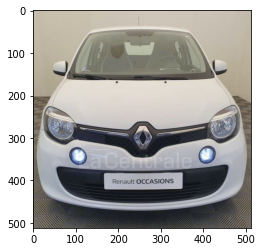

In [ ]:
predict2marques("donnees_comp/tests/twingoavec.jpeg")

Voici le résultat lorsqu'on cache le logo:

Cette image est à 1.93 pourcent peugeot et à 98.07 pourcent renault.


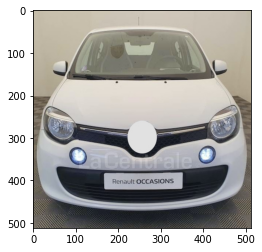

In [ ]:
predict2marques("donnees_comp/tests/twingosanslogo.jpeg")

Voici le résultat lorsqu'on cache les phares:

Cette image est à 0.00 pourcent peugeot et à 100.00 pourcent renault.


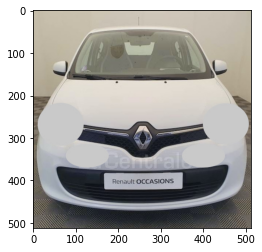

In [ ]:
predict2marques("donnees_comp/tests/twingosansphares.jpeg")

Voici le résultat lorsqu'on cache les phares et le logo:

Cette image est à 67.43 pourcent peugeot et à 32.57 pourcent renault.


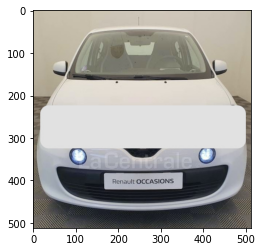

In [ ]:
predict2marques("donnees_comp/tests/twingosansavant.jpeg")

On constate que si on enlève soit le logo soit les phares, la prédiction ne change quasiment pas de l'image témoin. Mais, si on cache à la fois le logo et les phares, l'algorithme se trompe. En effet, une twingo sans logo ni phares renseemble à une Peugeot 108 de part ses proportions.

####2.2.2 Modèle avec "activation map"

On définit les deux fonctions suivantes permettant d'afficher le poids de chaque pixel lors de la dernière couche de convolution.

In [ ]:
def get_output_layer(model, layer_name):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

In [ ]:
def visualize_class_activation_map(model_path, img_path, output_path):
        model = models.load_model(model_path)
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape
        img = np.array([np.transpose(np.float32(original_img), (0, 1, 2))])
        class_weights = model.layers[-1].get_weights()[0]
        layer_name=model.layers[-3].name
        final_conv_layer = get_output_layer(model, layer_name)
        get_output = K.function([model.layers[0].input], \
                    [final_conv_layer.output,
        model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]
        #Création de l'activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
        target_class = 1
        conv_outputs=conv_outputs.reshape(32*32*128,1)
        cam2=conv_outputs*class_weights
        cam2=cam2.reshape(32*32,128)
        cam3=np.sum(cam2,axis=1)
        cam=cam3.reshape(32,32)
        plt.imshow(cam,cmap='viridis')
        plt.title("activation map lors de la dernière couche de convolution")

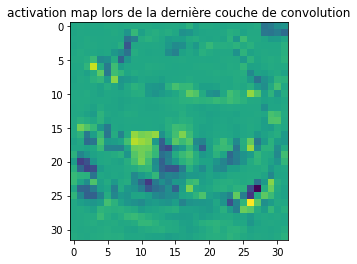

In [ ]:
visualize_class_activation_map('save_best.h5', 'donnees_comp/tests/P108.jpeg', 'donnees_comp')

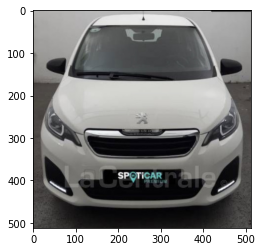

In [ ]:
image=mpimg.imread("donnees_comp/tests/P108.jpeg")
plt.imshow(image)

On remarque que le résultat obtenu suite à cette méthode concorde avec celui obtenu grâce à notre méthode expérimentale. En effet, on voit que l'ensemble formé par la calandre, les feux et le logo est ce sur quoi les kernels se concentrent pour l'identification du véhicule.

##3 Modèle de classification "Softmax"

Dans cette troisième partie on s'interesse à trois classes différentes: Peugeot, Renault et Autres. On change alors de modèle car ce n'est plus un modèle binaire. On utilise alors un système de type Softmax.

In [ ]:
train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    "donnees_comp/3marques",
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    "donnees_comp/3marques",
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1615 files belonging to 3 classes.
Using 1292 files for training.
Found 1615 files belonging to 3 classes.
Using 323 files for validation.


In [ ]:
def make_model2(input_shape,num_classes):
  inputs = keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = layers.experimental.preprocessing.Rescaling(1./255)(x)

  x = Conv2D(16,(3,3),padding='same',input_shape=(500,500,3),activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(32,(3,3),padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(64,(3,3),padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(128,(3,3),padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Flatten()(x)
  outputs = Dense(3,activation='softmax')(x)
  return keras.Model(inputs, outputs)
model2 = make_model2(input_shape=image_size + (3,), num_classes=2)
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 32)      0   

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_best2.h5",save_best_only=True,),
]
model2.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=["accuracy"],
)
history2=model2.fit(
    train_ds2, epochs=epochs, callbacks=callbacks, validation_data=val_ds2,
)

Epoch 1/30
81/81 [==============================] - 23s 266ms/step - loss: 2.1877 - accuracy: 0.3831 - val_loss: 1.1072 - val_accuracy: 0.4830
Epoch 2/30
81/81 [==============================] - 20s 246ms/step - loss: 0.9911 - accuracy: 0.5536 - val_loss: 0.6242 - val_accuracy: 0.7276
Epoch 3/30
81/81 [==============================] - 20s 244ms/step - loss: 0.6611 - accuracy: 0.7401 - val_loss: 0.7207 - val_accuracy: 0.6780
Epoch 4/30
81/81 [==============================] - 20s 246ms/step - loss: 0.4989 - accuracy: 0.7903 - val_loss: 0.3957 - val_accuracy: 0.8359
Epoch 5/30
81/81 [==============================] - 20s 245ms/step - loss: 0.3474 - accuracy: 0.8744 - val_loss: 0.3346 - val_accuracy: 0.8824
Epoch 6/30
81/81 [==============================] - 20s 245ms/step - loss: 0.2869 - accuracy: 0.8801 - val_loss: 0.5698 - val_accuracy: 0.7926
Epoch 7/30
81/81 [==============================] - 20s 245ms/step - loss: 0.2239 - accuracy: 0.9168 - val_loss: 0.3138 - val_accuracy: 0.8824

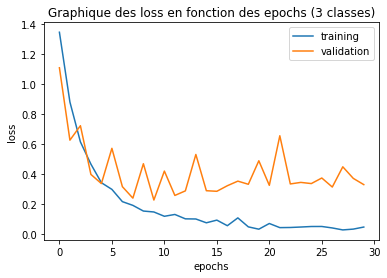

In [ ]:
plt.plot(history2.history['loss'],label='training')
plt.plot(history2.history['val_loss'],label='validation')
plt.title('Graphique des loss en fonction des epochs (3 classes)')
plt.xlabel('epochs'); plt.ylabel('loss'); plt.legend()

In [ ]:
model2.load_weights("save_best2.h5")

On définit maintenant une fonction qui prédit à quelle classe appartient une image:

In [ ]:
def predict3classes(path_image):
  image=mpimg.imread(path_image)
  plt.imshow(image)
  img = keras.preprocessing.image.load_img(
    path_image, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model2.predict(img_array)
  score = predictions[0]
  print(
    "Cette image est à %.2f pourcent autre, à %.2f pourcent Peugeot et à %.2f pourcent Renault."
    % (100 * score[0], 100 * score[1], 100 * score[2])
  )

Cette image est à 100.00 pourcent autre, à 0.00 pourcent Peugeot et à 0.00 pourcent Renault.


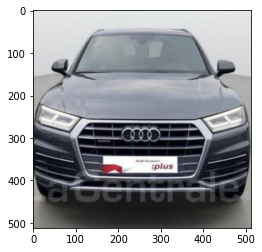

In [ ]:
predict3classes("donnees_comp/tests/autres/audi.jpeg")

Cette image est à 99.32 pourcent autre, à 0.02 pourcent Peugeot et à 0.66 pourcent Renault.


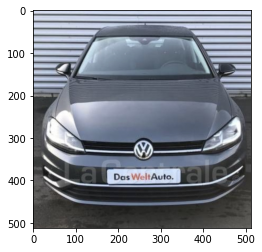

In [ ]:
predict3classes("donnees_comp/tests/autres/volkswagen1.jpeg")

##4 Conclusion
Ce projet nous a permis de découvrir ce qu’était réellement le machine learning. Avant d’entamer cette UE, nous pensions que de tels algorithmes de classification étaient composés d’un enchainement de boucles « if ». La réalité est toute autre comme nous l’avons vu dans ce projet.
Cette UE nous a également donné la possibilité de réaliser un projet que nous avions en tête depuis longtemps et qui nous tenait à coeur, comme nous vous l’avons expliqué dans l’introduction. \\
Avec une modélisation en trois dimensions des véhicules et un bien plus grand échantillon, nous pourrions créer un véritable « shazam des voitures » qui identifierait la marque ainsi que le modèle d’une voiture à partir d’une simple photo.